<a href="https://colab.research.google.com/github/jjasira/Graph-Theory/blob/main/GraphTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bipartite Graphs**

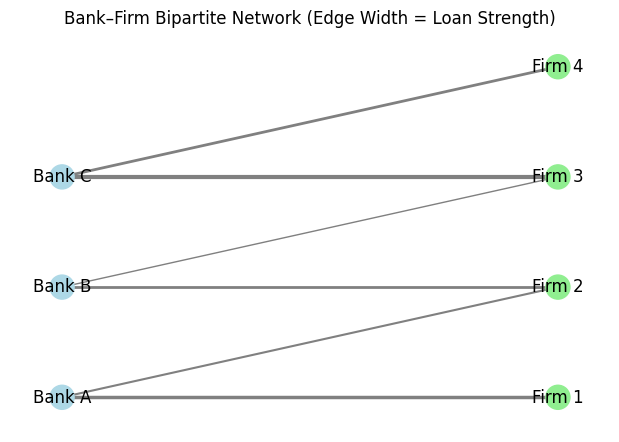

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# --- 1. Define node sets ---
banks = ["Bank A", "Bank B", "Bank C"]
firms = ["Firm 1", "Firm 2", "Firm 3", "Firm 4"]

# --- 2. Define weighted edges: (bank, firm, loan_exposure) ---
edges = [
    ("Bank A", "Firm 1", 5.0),
    ("Bank A", "Firm 2", 3.0),
    ("Bank B", "Firm 2", 4.0),
    ("Bank B", "Firm 3", 2.0),
    ("Bank C", "Firm 3", 6.0),
    ("Bank C", "Firm 4", 4.0),
]

# --- 3. Create bipartite graph ---
B = nx.Graph()
B.add_nodes_from(banks, bipartite=0)
B.add_nodes_from(firms, bipartite=1)
B.add_weighted_edges_from(edges)

# --- 4. Visualize the bipartite network ---
plt.figure(figsize=(6,4))
pos = {node: (0, i) for i, node in enumerate(banks)}
pos.update({node: (1, i) for i, node in enumerate(firms)})
weights = [B[u][v]["weight"] for u, v in B.edges()]
nx.draw(
    B,
    pos,
    with_labels=True,
    node_color=["lightblue" if n in banks else "lightgreen" for n in B.nodes()],
    width=[w / 2 for w in weights],  # scale weight for visibility
    edge_color="gray"
)

plt.title("Bank–Firm Bipartite Network (Edge Width = Loan Strength)")
plt.axis("off")
plt.show()

Now, we can build our adjacency matrix and use cosine similarity to evaluate the connections:

In [2]:
# --- Build biadjacency matrix (banks x firms) ---
from networkx.algorithms import bipartite

biadjacency = bipartite.biadjacency_matrix(B, row_order=banks, column_order=firms, weight="weight").toarray()
biadjacency_df = pd.DataFrame(biadjacency, index=banks, columns=firms)
print("Biadjacency Matrix (banks × firms):")
display(biadjacency_df)

Biadjacency Matrix (banks × firms):


,Firm 1,Firm 2,Firm 3,Firm 4
Bank A,5.0,3.0,0.0,0.0
Bank B,0.0,4.0,2.0,0.0
Bank C,0.0,0.0,6.0,4.0


In [3]:
# --- Cosine similarity projection ---
similarity = cosine_similarity(biadjacency)
sim_df = pd.DataFrame(similarity, index=banks, columns=banks)
print("Cosine Similarity between Banks (based on shared borrowers):")
display(sim_df)

Cosine Similarity between Banks (based on shared borrowers):


,Bank A,Bank B,Bank C
Bank A,1.000000,0.460179,0.000000
Bank B,0.460179,1.000000,0.372104
Bank C,0.000000,0.372104,1.000000


We can then use projections to evaluate the connections between banks based on shared firms

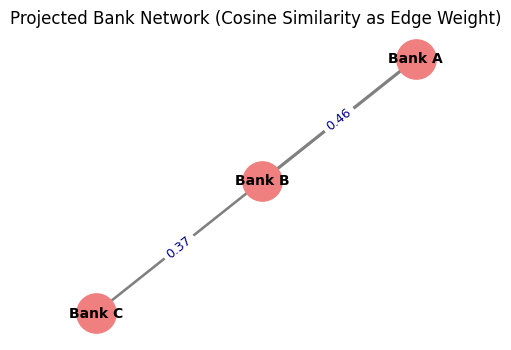

In [4]:
G_proj = nx.Graph()
for i in range(len(banks)):
    for j in range(i + 1, len(banks)):
        if similarity[i, j] > 0:
            G_proj.add_edge(banks[i], banks[j], weight=similarity[i, j])

# --- Visualize projection ---
plt.figure(figsize=(5, 4))
pos_proj = nx.spring_layout(G_proj, seed=42)

weights_proj = [G_proj[u][v]["weight"] * 5 for u, v in G_proj.edges()]
labels = { (u, v): f"{G_proj[u][v]['weight']:.2f}" for u, v in G_proj.edges() }

nx.draw_networkx_nodes(G_proj, pos_proj, node_color="lightcoral", node_size=800)
nx.draw_networkx_labels(G_proj, pos_proj, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G_proj, pos_proj, width=weights_proj, edge_color="gray")
nx.draw_networkx_edge_labels(G_proj, pos_proj, edge_labels=labels, font_color="darkblue", font_size=9)

plt.title("Projected Bank Network (Cosine Similarity as Edge Weight)")
plt.axis("off")
plt.show()

In [5]:
G_dist = nx.Graph()
for u, v, data in G_proj.edges(data=True):
    sim = data["weight"]
    # avoid division by zero
    dist = 1 / sim if sim > 0 else np.inf
    G_dist.add_edge(u, v, weight=dist)

# --- Shortest path lengths (weighted) ---
shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G_dist, weight="weight"))

print("Shortest Path Distances Between Banks:\n")
for source, targets in shortest_paths.items():
    print(f"{source}: {targets}")

# --- Average path length ---
avg_path_length = nx.average_shortest_path_length(G_dist, weight="weight")
print(f"Average Path Length (weighted by inverse similarity): {avg_path_length:.3f}")

# --- Diameter (longest shortest path) ---
diameter = 0
for s in shortest_paths:
    for t in shortest_paths[s]:
        if shortest_paths[s][t] > diameter:
            diameter = shortest_paths[s][t]
print(f"Network Diameter (max shortest path): {diameter:.3f}")

# --- Clustering Coefficient ---
# For weighted networks, this measures triangle density weighted by edge strengths
clustering_coeffs = nx.clustering(G_proj, weight="weight")
avg_clustering = nx.average_clustering(G_proj, weight="weight")

print("Local Clustering Coefficients:")
for node, coeff in clustering_coeffs.items():
    print(f"{node}: {coeff:.3f}")

print(f"Average Clustering Coefficient: {avg_clustering:.3f}")

Shortest Path Distances Between Banks:

Bank A: {'Bank A': 0, 'Bank B': np.float64(2.173067468400883), 'Bank C': np.float64(4.860486717833733)}
Bank B: {'Bank B': 0, 'Bank A': np.float64(2.173067468400883), 'Bank C': np.float64(2.6874192494328497)}
Bank C: {'Bank C': 0, 'Bank B': np.float64(2.6874192494328497), 'Bank A': np.float64(4.860486717833733)}
Average Path Length (weighted by inverse similarity): 3.240
Network Diameter (max shortest path): 4.860
Local Clustering Coefficients:
Bank A: 0.000
Bank B: 0.000
Bank C: 0.000
Average Clustering Coefficient: 0.000


**An Exaple of a Random Network**
To illustrate all these concepts, let's work on creating a random network (ER style) of investors and investments in mutual funds.

In [6]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


n_investors = 15
n_funds     = 12
p_link      = 0.18   # probability an investor holds a fund (ER-style bipartite)
rng_seed    = 42
np.random.seed(rng_seed)

investors = [f"Inv_{i}" for i in range(n_investors)]
funds     = [f"Fund_{j}" for j in range(n_funds)]

# Build random bipartite graph (ER bipartite)
B = nx.Graph()
B.add_nodes_from(investors, bipartite=0)
B.add_nodes_from(funds, bipartite=1)

for inv in investors:
    for fund in funds:
        if np.random.rand() < p_link:
            w = np.random.randint(1, 6) # random weights in links between 1 and 5 (millions)
            B.add_edge(inv, fund, weight=w)


m_edges = B.number_of_edges()
print(f"Bipartite edges (investor–fund links): {m_edges}")

Bipartite edges (investor–fund links): 33


In [7]:
# Biadjacency matrix Investors × Funds (weights)
biadj = bipartite.biadjacency_matrix(B, row_order=investors, column_order=funds, weight="weight").toarray()
biadj_df = pd.DataFrame(biadj, index=investors, columns=funds)
display(biadj_df)

,Fund_0,Fund_1,Fund_2,Fund_3,Fund_4,Fund_5,Fund_6,Fund_7,Fund_8,Fund_9,Fund_10,Fund_11
Inv_0,0,0,0,0,3,3,0,0,0,2,0,0
Inv_1,4,0,0,0,0,0,0,4,0,0,3,0
Inv_2,0,0,0,0,0,1,0,0,0,4,0,0
Inv_3,0,0,1,0,0,0,0,0,0,0,0,0
Inv_4,0,0,0,4,5,0,0,0,0,0,0,5
Inv_5,1,0,0,3,0,0,0,0,0,0,0,0
Inv_6,0,5,0,0,0,0,3,0,0,0,0,0
Inv_7,0,5,0,0,0,0,0,5,0,0,0,0
Inv_8,0,0,0,0,4,0,0,0,0,0,0,0
Inv_9,1,0,5,0,3,0,0,4,0,1,0,2


Now we can project this network to an investor-investors network to analyze the links between investors given their investments into different funds. We will first look simply at the number of "co-holdings" to get a raw estimate. Then, we can implement the classic cosine similarity projection:

In [8]:
# Co-holdings projection:
cohold = biadj @ biadj.T
np.fill_diagonal(cohold, 0)
A_count = pd.DataFrame(cohold, index=investors, columns=investors)

G_proj_count = nx.Graph()
for i, u in enumerate(investors):
    for j, v in enumerate(investors):
        if j <= i:
            continue
        if A_count.iloc[i, j] > 0:
            G_proj_count.add_edge(u, v, weight=A_count.iloc[i, j])

# Cosine similarity projection
cos = cosine_similarity(biadj)
np.fill_diagonal(cos, 0.0)
A_cos = pd.DataFrame(cos, index=investors, columns=investors)

G_proj_cos = nx.Graph()
for i, u in enumerate(investors):
    for j, v in enumerate(investors):
        if j <= i:
            continue
        if A_cos.iloc[i, j] > 0:
            G_proj_cos.add_edge(u, v, weight=A_cos.iloc[i, j])

print(f"\nInvestor–Investor edges (co-holdings ≥1): {G_proj_count.number_of_edges()}")
print(f"Investor–Investor edges (cosine > 0):     {G_proj_cos.number_of_edges()}")



Investor–Investor edges (co-holdings ≥1): 30
Investor–Investor edges (cosine > 0):     30


For ease of visualization, we can also plot projected network, for instance the cosine-based one:

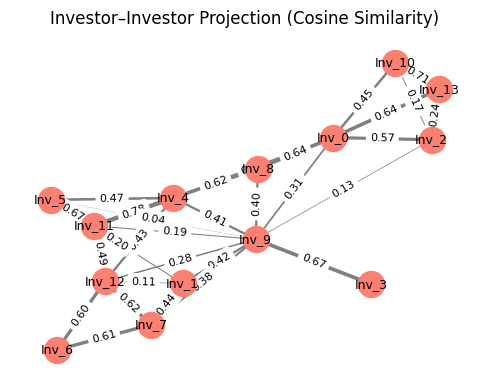

In [9]:
plt.figure(figsize=(5,4))
pos = nx.spring_layout(G_proj_cos, seed=rng_seed)
nx.draw_networkx_nodes(G_proj_cos, pos, node_color="salmon", node_size=350)
nx.draw_networkx_labels(G_proj_cos, pos, font_size=9)
w = [G_proj_cos[u][v]["weight"]*4 for u,v in G_proj_cos.edges()]
nx.draw_networkx_edges(G_proj_cos, pos, width=w, edge_color="gray")
nx.draw_networkx_edge_labels(
    G_proj_cos, pos,
    edge_labels={(u,v): f"{G_proj_cos[u][v]['weight']:.2f}" for u,v in G_proj_cos.edges()},
    font_size=8
)
plt.title("Investor–Investor Projection (Cosine Similarity)")
plt.axis("off")
plt.tight_layout()
plt.show()

Finally, we can analyze connectedness metrics based on these projections:

In [10]:
# Connectedness metrics on projection (use cosine-distance)

def metrics_on_graph(G, weighted=False):
    if G.number_of_nodes() == 0 or nx.number_connected_components(G) > 1:
        if G.number_of_nodes() == 0:
            return {"avg_deg": 0, "density": 0, "avg_path": np.nan, "diameter": np.nan, "avg_clust": 0}
        comp = max(nx.connected_components(G), key=len)
        H = G.subgraph(comp).copy()
    else:
        H = G

    avg_deg = sum(dict(H.degree()).values()) / H.number_of_nodes()
    density = nx.density(H)

    if weighted:
        Hdist = nx.Graph()
        for u, v, d in H.edges(data=True):
            sim = d.get("weight", 1.0)
            dist = 1.0 / sim if sim > 0 else np.inf
            Hdist.add_edge(u, v, weight=dist)
        avg_path = nx.average_shortest_path_length(Hdist, weight="weight") if Hdist.number_of_edges() else np.nan
        avg_clust = nx.average_clustering(H, weight="weight")
        sp = dict(nx.all_pairs_dijkstra_path_length(Hdist, weight="weight"))
        diam = max(max(d.values()) for d in sp.values()) if Hdist.number_of_edges() else np.nan
    else:
        avg_path = nx.average_shortest_path_length(H) if H.number_of_edges() else np.nan
        avg_clust = nx.average_clustering(H)
        sp = dict(nx.all_pairs_shortest_path_length(H))
        diam = max(max(d.values()) for d in sp.values()) if H.number_of_edges() else np.nan

    return {
        "n_nodes_cc": H.number_of_nodes(),
        "n_edges_cc": H.number_of_edges(),
        "avg_deg": avg_deg,
        "density": density,
        "avg_path": avg_path,
        "diameter": diam,
        "avg_clust": avg_clust,
    }

m_count = metrics_on_graph(G_proj_count, weighted=False)
m_cos   = metrics_on_graph(G_proj_cos,   weighted=True)

print("Co-holdings (unweighted):", m_count)
print("Cosine similarity (weighted):", m_cos)

Co-holdings (unweighted): {'n_nodes_cc': 14, 'n_edges_cc': 30, 'avg_deg': 4.285714285714286, 'density': 0.32967032967032966, 'avg_path': 1.901098901098901, 'diameter': 4, 'avg_clust': 0.6611111111111111}
Cosine similarity (weighted): {'n_nodes_cc': 14, 'n_edges_cc': 30, 'avg_deg': 4.285714285714286, 'density': 0.32967032967032966, 'avg_path': np.float64(4.459277234097334), 'diameter': np.float64(8.75969017836465), 'avg_clust': 0.35541101211798426}


As you can see, both projections (count- and cosine-based) deliver similar (but not quite identical) metrics. So, sometimes we would like to opt for one or another form of projection. Most of the time, however, we would opt for the cosine metric if the strength of the links is an important factor.